In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as rq
from bs4 import BeautifulSoup as bs
import re
import pickle

In [2]:
# Found using Postman and intercepting traffics while visiting topuniversities.com
top_universities_url = 'https://www.topuniversities.com'
top_universities_ranking_url = top_universities_url + '/sites/default/files/qs-rankings-data/357051.txt'

the_universities_url = 'https://www.timeshighereducation.com'
the_universities_ranking_url = the_universities_url + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

## TopUniversities.com

TopUniversities provides a JSON containing the list of universities they ranked, but the JSON does not contain all the required informations. So we need to visit each university web page to retreive the missing informations. To avoid making thousands of requests, we limited the fetching to the top 200 universities listed. We serialize the result so we don't need to scrap againg the data if we restart the kernel.

The selectors used to extract the values from the html document were found by using the inspector on any university's web page.

In [3]:
def match_number(text):
    ''' Remove any characters from the given string that is not part of a real number.
        This approximation is good enough to scrap both Top Universities and Times Higher Education.
        For documentation, here is a real number regex: [-+]?[0-9]*\.?[0-9]+
    '''
    return float(re.sub('[^-+0-9.]', '', text))

def extract_number(html, selector):
    ''' A simple helper that extract a real number from an html document using the provided selector. '''
    number_tag = html.select_one(selector)
    if number_tag is None:
        return float('NaN')
    else:
        return match_number(number_tag.get_text())

def fetch_top_university_infos(university):
    ''' Fetch the extra data required for a university from the web page, using the provided university from the JSON.
        We just extract the required informations and put them in a dict that will be part of the final DataFrame.
    '''
    university_request = rq.get(top_universities_url + university['url'])
    university_html = bs(university_request.text, 'html.parser')
    university_data = dict()
    
    # Scrap data from the JSON and the Webpage
    university_data['name'] = university['title']
    university_data['rank'] = int(match_number(university['rank_display']))
    university_data['region'] = university['region']
    university_data['country'] = university['country']
    university_data['faculty_total'] = extract_number(university_html, 'div.faculty.total div.number')
    university_data['faculty_inter'] = extract_number(university_html, 'div.faculty.inter div.number')
    university_data['faculty_local'] = university_data['faculty_total'] - university_data['faculty_inter']
    university_data['student_total'] = extract_number(university_html, 'div.student.total div.number')
    university_data['student_inter'] = extract_number(university_html, 'div.inter.total div.number')
    university_data['student_local'] = university_data['student_total'] - university_data['student_inter']
    
    return university_data

try:
    # Try to load the serialized data
    top_universities_file = open('top_universities.pickle', 'rb')
    top_universities = pickle.load(top_universities_file)
except:
    # If loading from the serialized data failed, scrap from the web!
    top_universities_json = (rq.get(top_universities_ranking_url).json())['data']
    top_universities = pd.DataFrame(list(map(fetch_top_university_infos, top_universities_json[0:200])))
    
    top_universities.region = top_universities.region.astype('category')
    top_universities.country = top_universities.country.astype('category')
    
    # Serialize the result for future runs
    top_universities_file = open('top_universities.pickle', 'wb')
    pickle.dump(top_universities, top_universities_file)
    
top_universities

,country,faculty_inter,faculty_local,faculty_total,name,rank,region,student_inter,student_local,student_total
0,United States,1679.0,1303.0,2982.0,Massachusetts Institute of Technology (MIT),1,North America,3717.0,7350.0,11067.0
1,United States,2042.0,2243.0,4285.0,Stanford University,2,North America,3611.0,12267.0,15878.0
2,United States,1311.0,3039.0,4350.0,Harvard University,3,North America,5266.0,17163.0,22429.0
3,United States,350.0,603.0,953.0,California Institute of Technology (Caltech),4,North America,647.0,1608.0,2255.0
4,United Kingdom,2278.0,3212.0,5490.0,University of Cambridge,5,Europe,6699.0,12071.0,18770.0
5,United Kingdom,2964.0,3786.0,6750.0,University of Oxford,6,Europe,7353.0,12367.0,19720.0
6,United Kingdom,2554.0,3791.0,6345.0,UCL (University College London),7,Europe,14854.0,16226.0,31080.0
7,United Kingdom,2071.0,1859.0,3930.0,Imperial College London,8,Europe,8746.0,7344.0,16090.0
8,United States,635.0,1814.0,2449.0,University of Chicago,9,North America,3379.0,10178.0,13557.0
9,Switzerland,1886.0,591.0,2477.0,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,7563.0,12252.0,19815.0


In [4]:
''' The Times ranking doesn't provide the university's region.
    We create the mapping Country => Region using the data from Top Universities, so that we don't have to write it manually.
'''
country_regions = dict()
for country_region_pair, universities in top_universities.groupby(['country', 'region']):
    country_regions[country_region_pair[0]] = country_region_pair[1]
    
# Manually add missing data for the Times ranking
country_regions['Luxembourg'] = 'Europe'
country_regions['Russian Federation'] = 'Europe'

In [5]:
# Sort the universities by faculty/student ratio and international students/local students ratio
def ratio_stats(universities):
    ''' Sort the universities using the different ratios we were asked about.
        Sort by falculty/student ration and international students/local students ratio.
    '''
    universities['faculty_student_ratio'] = universities.faculty_total / universities.student_total
    universities['inter_student_ratio'] = universities.student_inter / universities.student_total
    
    top_by_faculty = (universities.sort_values('faculty_student_ratio', ascending = False))[:20]
    top_by_inter = (universities.sort_values('inter_student_ratio', ascending = False))[:20]
    
    return (top_by_faculty, top_by_inter)

In [6]:
# Top universities, using ratios
top_universities_by_faculty, top_universities_by_inter = ratio_stats(top_universities)

# Top universities by country, using ratios
top_country = top_universities.groupby('country').sum()
top_country_by_faculty, top_country_by_inter = ratio_stats(top_country)

# Top universities by region, using ratios
top_regions = top_universities.groupby('region').sum()
top_regions_by_faculty, top_regions_by_inter = ratio_stats(top_regions)

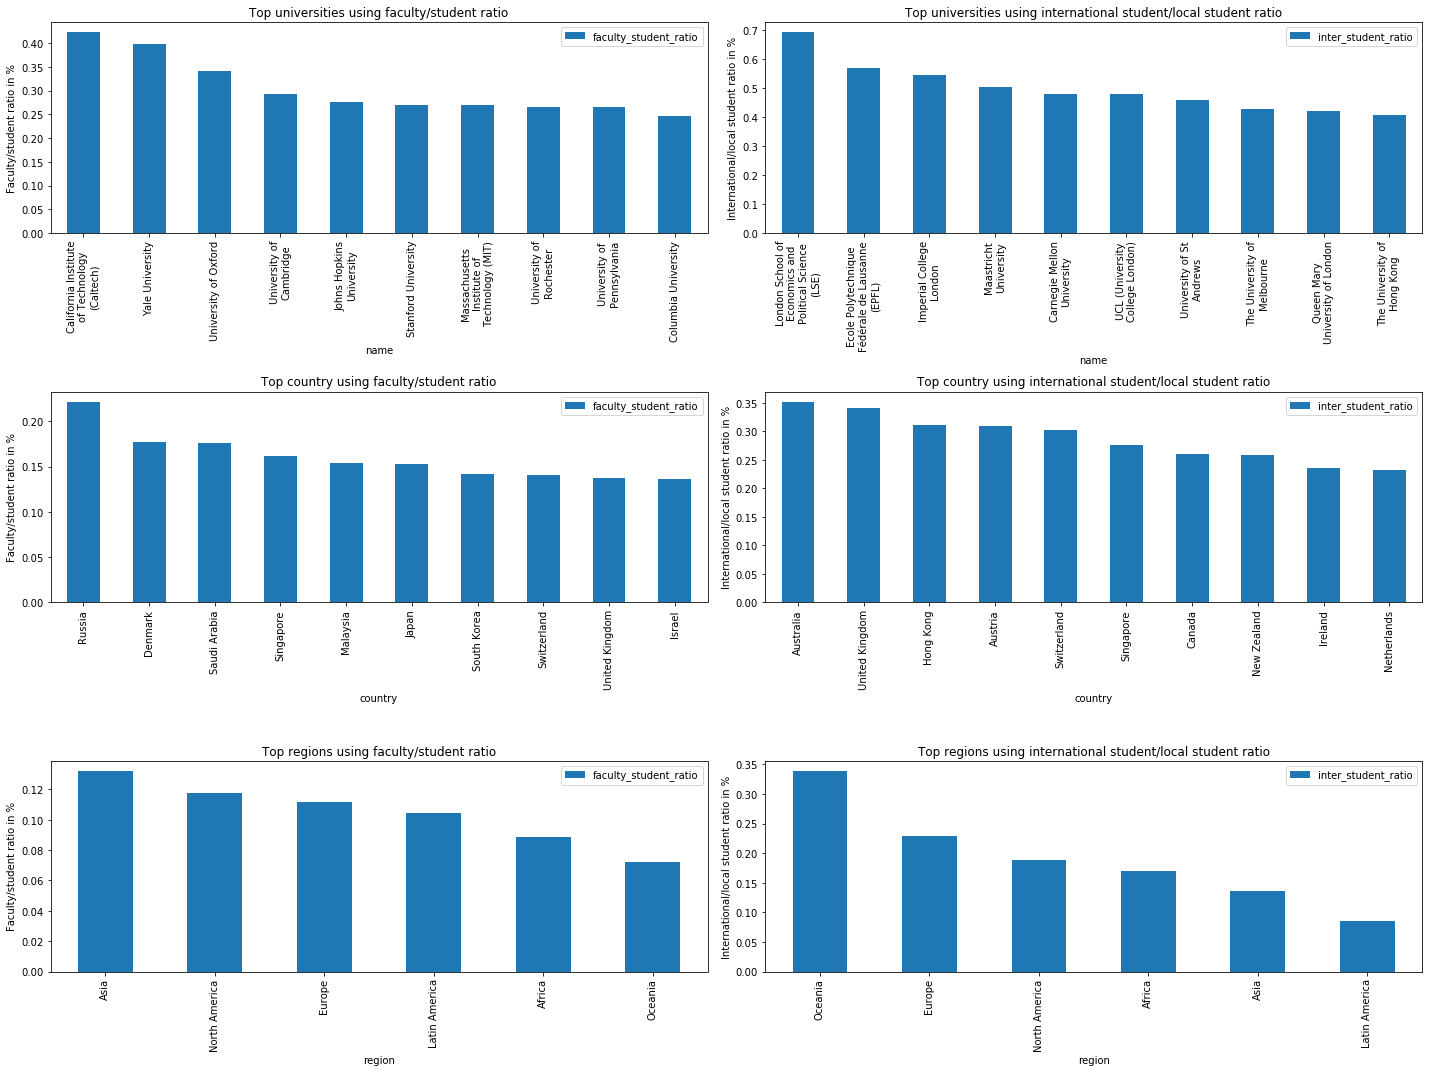

In [7]:
from textwrap import wrap

def generate_labels(names):
    return pd.Series(names).apply(lambda n: "\n".join(wrap(n, 20)))

fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (20, 15))

labels = generate_labels(top_universities_by_faculty[0:10]['name'])
plot = top_universities_by_faculty[0:10].plot(labels, 'faculty_student_ratio', kind = 'bar', ax = axes[0,0])
plot.set_title('Top universities using faculty/student ratio')
plot.set_ylabel('Faculty/student ratio in %')

labels = generate_labels(top_universities_by_inter[0:10]['name'])
plot = top_universities_by_inter[0:10].plot(labels, 'inter_student_ratio', kind = 'bar', ax = axes[0,1])
plot.set_title('Top universities using international student/local student ratio')
plot.set_ylabel('International/local student ratio in %')

labels = generate_labels(top_country_by_faculty[0:10].index)
plot = top_country_by_faculty[0:10].plot(labels, 'faculty_student_ratio', kind = 'bar', ax = axes[1,0])
plot.set_title('Top country using faculty/student ratio')
plot.set_ylabel('Faculty/student ratio in %')

labels = generate_labels(top_country_by_inter[0:10].index)
plot = top_country_by_inter[0:10].plot(labels, 'inter_student_ratio', kind = 'bar', ax = axes[1,1])
plot.set_title('Top country using international student/local student ratio')
plot.set_ylabel('International/local student ratio in %')

labels = generate_labels(top_regions_by_faculty[0:10].index)
plot = top_regions_by_faculty[0:10].plot(labels, 'faculty_student_ratio', kind = 'bar', ax = axes[2,0])
plot.set_title('Top regions using faculty/student ratio')
plot.set_ylabel('Faculty/student ratio in %')

labels = generate_labels(top_regions_by_inter[0:10].index)
plot = top_regions_by_inter[0:10].plot(labels, 'inter_student_ratio', kind = 'bar', ax = axes[2,1])
plot.set_title('Top regions using international student/local student ratio')
plot.set_ylabel('International/local student ratio in %')

plt.tight_layout()

## Times Higher Education

Times Higher Education also provides a JSON containing all the universities. This JSON already contains all the informations concerning the university, so scrapping the university's web page won't give us any more data.

Some informations are given to us as ratio (ex.: stats_student_staff_ratio), but we compute the number of people linked to those ratios to get similar values than Top Universities.

We also use the previously computed mapping from Country => Region to fill this information that is missing from the JSON.

Finally, we again serialize the result so we don't need to scrap again.

In [8]:
def fetch_the_university_infos(university):
    ''' Reformat the data from the JSON so we have the same layout than with Top Universities.
        We compute the fields student_inter and faculty_total using the ratios provided by the JSON.
        We can't unfortunately compute the amount of international and local faculty members.
    '''
    university_data = dict()
    
    student_faculty_ratio = match_number(university['stats_student_staff_ratio'])
    inter_student_ratio = match_number(university['stats_pc_intl_students']) / 100.0
    
    # Scrap data from the JSON, some computation required
    university_data['name'] = university['name']
    university_data['rank'] = int(match_number(university['rank']))
    university_data['region'] = country_regions[university['location']]
    university_data['country'] = university['location']
    university_data['student_total'] = int(match_number(university['stats_number_students']))
    university_data['student_inter'] = int(university_data['student_total'] * inter_student_ratio)
    university_data['student_local'] = university_data['student_total'] - university_data['student_inter']
    university_data['faculty_total'] = int(university_data['student_total'] / student_faculty_ratio)
    university_data['faculty_inter'] = float('NaN')
    university_data['faculty_local'] = float('NaN')
    
    return university_data
    
try:
    # Try to load the serialized data
    the_universities_file = open('the_universities.pickle', 'rb')
    the_universities = pickle.load(the_universities_file)
except:
    # If loading from the serialized data failed, scrap from the web!
    the_universities_json = (rq.get(the_universities_ranking_url).json())['data']
    the_universities = pd.DataFrame(list(map(fetch_the_university_infos, the_universities_json[0:200])))
        
    the_universities.region = the_universities.region.astype('category')
    the_universities.country = the_universities.country.astype('category')
    
    # Serialize the result for future runs
    the_universities_file = open('the_universities.pickle', 'wb')
    pickle.dump(the_universities, the_universities_file)
    
the_universities

,country,faculty_inter,faculty_local,faculty_total,name,rank,region,student_inter,student_local,student_total
0,United Kingdom,NaN,NaN,1822,University of Oxford,1,Europe,7755,12654,20409
1,United Kingdom,NaN,NaN,1687,University of Cambridge,2,Europe,6436,11953,18389
2,United States,NaN,NaN,339,California Institute of Technology,3,North America,596,1613,2209
3,United States,NaN,NaN,2112,Stanford University,3,North America,3485,12360,15845
4,United States,NaN,NaN,1284,Massachusetts Institute of Technology,5,North America,3800,7377,11177
5,United States,NaN,NaN,2283,Harvard University,6,North America,5284,15042,20326
6,United States,NaN,NaN,958,Princeton University,7,North America,1909,6046,7955
7,United Kingdom,NaN,NaN,1390,Imperial College London,8,Europe,8721,7136,15857
8,United States,NaN,NaN,2181,University of Chicago,9,North America,3381,10144,13525
9,Switzerland,NaN,NaN,1317,ETH Zurich – Swiss Federal Institute of Techno...,10,Europe,7308,11925,19233


In [9]:
# Top universities, using ratios
the_universities_by_faculty, the_universities_by_inter = ratio_stats(the_universities)

# Top universities by country, using ratios
the_country = the_universities.groupby('country').sum()
the_country_by_faculty, the_country_by_inter = ratio_stats(the_country)

# Top universities by region, using ratios
the_regions = the_universities.groupby('region').sum()
the_regions_by_faculty, the_regions_by_inter = ratio_stats(the_regions)

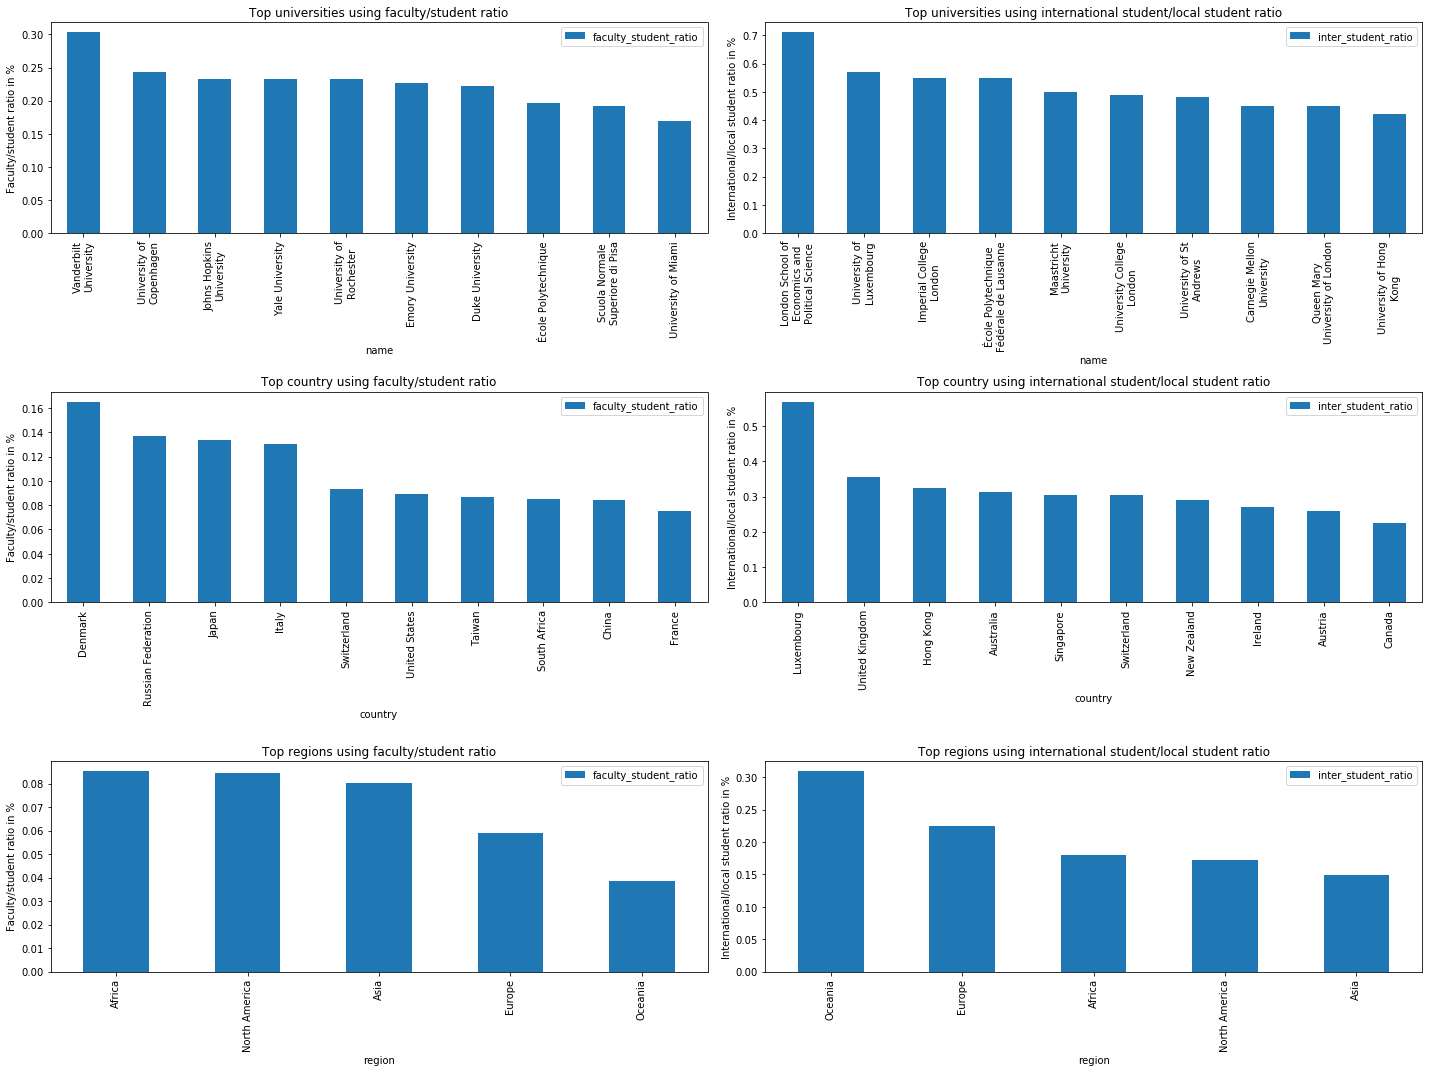

In [10]:
from textwrap import wrap

def generate_labels(names):
    return pd.Series(names).apply(lambda n: "\n".join(wrap(n, 20)))

fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (20, 15))

labels = generate_labels(the_universities_by_faculty[0:10]['name'])
plot = the_universities_by_faculty[0:10].plot(labels, 'faculty_student_ratio', kind = 'bar', ax = axes[0,0])
plot.set_title('Top universities using faculty/student ratio')
plot.set_ylabel('Faculty/student ratio in %')

labels = generate_labels(the_universities_by_inter[0:10]['name'])
plot = the_universities_by_inter[0:10].plot(labels, 'inter_student_ratio', kind = 'bar', ax = axes[0,1])
plot.set_title('Top universities using international student/local student ratio')
plot.set_ylabel('International/local student ratio in %')

labels = generate_labels(the_country_by_faculty[0:10].index)
plot = the_country_by_faculty[0:10].plot(labels, 'faculty_student_ratio', kind = 'bar', ax = axes[1,0])
plot.set_title('Top country using faculty/student ratio')
plot.set_ylabel('Faculty/student ratio in %')

labels = generate_labels(the_country_by_inter[0:10].index)
plot = the_country_by_inter[0:10].plot(labels, 'inter_student_ratio', kind = 'bar', ax = axes[1,1])
plot.set_title('Top country using international student/local student ratio')
plot.set_ylabel('International/local student ratio in %')

labels = generate_labels(the_regions_by_faculty[0:10].index)
plot = the_regions_by_faculty[0:10].plot(labels, 'faculty_student_ratio', kind = 'bar', ax = axes[2,0])
plot.set_title('Top regions using faculty/student ratio')
plot.set_ylabel('Faculty/student ratio in %')

labels = generate_labels(the_regions_by_inter[0:10].index)
plot = the_regions_by_inter[0:10].plot(labels, 'inter_student_ratio', kind = 'bar', ax = axes[2,1])
plot.set_title('Top regions using international student/local student ratio')
plot.set_ylabel('International/local student ratio in %')

plt.tight_layout()

# Merging datasets

In [11]:
from difflib import SequenceMatcher
from collections import defaultdict
from operator import itemgetter

def proximity(a, b):
    ''' Compute the proximity of two strings: a full match will return 1.0 and strings completely different will return 0.0.
        SequenceMatcher is a class that does the computation for us and return the result as a percentage using the .ratio() method.
        SequenceMatcher is part of difflib, which is part of core python libraries.
    '''
    return SequenceMatcher(None, a, b).ratio()

# We will compute the proximity of the name between all universities of the rankings
# That's why we loop on both dataframe (cross product)
proximities = dict()
for top_index, top_uni in top_universities.iterrows():
    for the_index, the_uni in the_universities.iterrows():
        # Skip if the universities are not within the same country
        if top_uni['country'] != the_uni['country']:
            continue
        
        prox = proximity(top_uni['name'], the_uni['name'])
        
        # Only keep good proximity to reduce work in the next phase
        if prox >= .5:
            proximities[(top_index, the_index)] = prox

In [12]:
# Prepare universities to be matched
top_universities['matched'] = False
the_universities['matched'] = False
the_universities['merge_name'] = None
the_universities['prox'] = 0.0
# Will be infered later
the_universities['faculty_inter'] = None
the_universities['faculty_local'] = None

# Sort match by quality, we want the best matches to be processed first in case of conflicts
best_matches = sorted(proximities.items(), key = itemgetter(1), reverse = True)

for indexes, proximity in best_matches:
    # Get a view on both unis
    top_uni, the_uni = top_universities.loc[indexes[0]], the_universities.loc[indexes[1]]
    
    # Do the match only if both are still free
    if not top_uni['matched'] and not the_uni['matched']:
        # Mark the universities as matched
        top_universities.loc[indexes[0],'matched'] = True
        the_universities.loc[indexes[1],'matched'] = True
        # Give the same name for the merge
        the_universities.loc[indexes[1],'prox'] = proximity
        the_universities.loc[indexes[1],'merge_name'] = top_uni['name']

# Use a join to merge the datasets using the name
merged_universities = top_universities.merge(the_universities[['faculty_inter', 'faculty_local', 'faculty_total',
                                                               'student_inter', 'student_local', 'student_total',
                                                               'rank', 'inter_student_ratio','merge_name']],
                                             suffixes=('_top','_the'), how='inner', 
                                             left_on='name', right_on='merge_name')

# Drop unused columns and (the only) row where we don't have faculty numbers
merged_universities.drop(['merge_name', 'matched'], axis=1, inplace=True)
merged_universities.drop(merged_universities[merged_universities['faculty_total_top'].isnull()].index, inplace=True)

# Infer these columns for the Times as they are missing from the original data
# We infer that the ratio between the local and international faculty is the same as in the TopUnivesities ranking
top_local_total_ratio = merged_universities['faculty_local_top']/merged_universities['faculty_total_top']
merged_universities['faculty_local_the'] = (top_local_total_ratio * merged_universities['faculty_total_the']).astype(int)
merged_universities['faculty_inter_the'] = merged_universities['faculty_total_the'] - merged_universities['faculty_local_the']

In [13]:
### Add some useful columns

# International / Local
merged_universities['inter_ratio'] = (merged_universities['faculty_inter_top'] + merged_universities['student_inter_top'])/(merged_universities['faculty_local_top'] + merged_universities['student_local_top'])
# Students / Faculty
merged_universities['student_faculty_ratio'] = 1/merged_universities['faculty_student_ratio']
# Percentage of international faculty members in the faculty
merged_universities['faculty_inter_ratio'] = merged_universities['faculty_inter_top']/merged_universities['faculty_total_top']
# Our own ranking based on the arithmetic average of the two rankings (with a small delta proportional to the difference in ranking, in order to break ties favoring the more consistently ranked)
merged_universities['arithmetic_ranking'] = (merged_universities['rank_top'] + merged_universities['rank_the'] + abs(merged_universities['rank_top'] - merged_universities['rank_the'])/200 ).rank().astype(int)

merged_universities

,country,faculty_inter_top,faculty_local_top,faculty_total_top,name,rank_top,region,student_inter_top,student_local_top,student_total_top,...,faculty_total_the,student_inter_the,student_local_the,student_total_the,rank_the,inter_student_ratio_the,inter_ratio,student_faculty_ratio,faculty_inter_ratio,arithmetic_ranking
0,United States,1679.0,1303.0,2982.0,Massachusetts Institute of Technology (MIT),1,North America,3717.0,7350.0,11067.0,...,1284,3800,7377,11177,5,0.339984,0.623599,3.711268,0.563045,2
1,United States,2042.0,2243.0,4285.0,Stanford University,2,North America,3611.0,12267.0,15878.0,...,2112,3485,12360,15845,3,0.219943,0.389593,3.705484,0.476546,1
2,United States,1311.0,3039.0,4350.0,Harvard University,3,North America,5266.0,17163.0,22429.0,...,2283,5284,15042,20326,6,0.259963,0.325562,5.156092,0.301379,6
3,United States,350.0,603.0,953.0,California Institute of Technology (Caltech),4,North America,647.0,1608.0,2255.0,...,339,596,1613,2209,3,0.269805,0.450927,2.366212,0.367261,3
4,United Kingdom,2278.0,3212.0,5490.0,University of Cambridge,5,Europe,6699.0,12071.0,18770.0,...,1687,6436,11953,18389,2,0.349992,0.587385,3.418944,0.414936,4
5,United Kingdom,2964.0,3786.0,6750.0,University of Oxford,6,Europe,7353.0,12367.0,19720.0,...,1822,7755,12654,20409,1,0.379979,0.638705,2.921481,0.439111,5
6,United Kingdom,2554.0,3791.0,6345.0,UCL (University College London),7,Europe,14854.0,16226.0,31080.0,...,2886,14848,15456,30304,16,0.489968,0.869661,4.898345,0.402522,11
7,United Kingdom,2071.0,1859.0,3930.0,Imperial College London,8,Europe,8746.0,7344.0,16090.0,...,1390,8721,7136,15857,8,0.549978,1.175378,4.094148,0.526972,7
8,United States,635.0,1814.0,2449.0,University of Chicago,9,North America,3379.0,10178.0,13557.0,...,2181,3381,10144,13525,9,0.249982,0.334723,5.535729,0.259290,8
9,Switzerland,1886.0,591.0,2477.0,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,7563.0,12252.0,19815.0,...,1317,7308,11925,19233,10,0.379972,0.735732,7.999596,0.761405,9


## Correlation matrix

(The negative correlation between the rank(s) and the different columns is due to having the best rank at 1 while the "worst" number in the columns is 0.)

In the correlation matrix below, we can see that:
 - **Corr. ~0.9**: the number of local faculty members (*faculty_local_xxx*) is a strong indicator of the size of the faculty in its whole (*faculty_total_xxx*) (and reciprocally)
 - **Corr. ~0.96**: same for the number of local students (*student_local_xxx*) and the total of students (*student_total_xxx*) 
 - **Corr. ~0.93**: the ratio of international students (*inter_student_ratio_xxx*) gives us a good information about the internationality of the whole university (*inter_ratio*)
 - **Corr. 0.55-0.61**: knowing the size of the student body (*student_total_xxx*) gives us some information about the size of the faculty (*faculty_total_xxx*)
 - **Corr. 0.66, 0.90-0.94**: the internationaliy ratio (*inter_ratio*) has a good correlation with the faculty internationality (*faculty_inter_ratio*) and an excellent correlation with the student international ratio (*student_inter_ratio_xxx*)

In [14]:
def colored_matrix(matrix, first_column=None):
    if first_column:
        columns = list(matrix.columns.values)
        columns.remove(first_column)
        columns.insert(0, first_column)
        matrix = matrix[columns]
        
    return matrix.style.bar(align='zero', color=['#d65f5f', '#5fba7d'])

# Correlation matrix with some colored bars for better visual
cols = sorted(merged_universities.columns.values)
corr_matrix = merged_universities[cols].corr()
colored_matrix(corr_matrix)

,arithmetic_ranking,faculty_inter_ratio,faculty_inter_the,faculty_inter_top,faculty_local_the,faculty_local_top,faculty_student_ratio,faculty_total_the,faculty_total_top,inter_ratio,inter_student_ratio_the,inter_student_ratio_top,rank_the,rank_top,student_faculty_ratio,student_inter_the,student_inter_top,student_local_the,student_local_top,student_total_the,student_total_top
arithmetic_ranking,1,-0.242642,-0.384923,-0.483983,-0.204382,-0.293129,-0.393827,-0.294482,-0.437561,-0.286407,-0.234614,-0.276619,0.919419,0.923912,0.274666,-0.289975,-0.290732,-0.0447655,-0.0468562,-0.110985,-0.121043
faculty_inter_ratio,-0.242642,1,0.457341,0.596793,-0.481856,-0.433853,0.0861958,-0.251286,-0.0812833,0.667532,0.636234,0.653016,-0.113745,-0.345941,-0.117843,0.32482,0.315832,-0.316498,-0.332535,-0.20126,-0.194598
faculty_inter_the,-0.384923,0.457341,1,0.813299,0.383445,0.325145,0.226055,0.642663,0.604585,0.21998,0.165745,0.220952,-0.255392,-0.45605,-0.215415,0.418065,0.441369,0.254504,0.225023,0.328699,0.314633
faculty_inter_top,-0.483983,0.596793,0.813299,1,0.0726454,0.303877,0.325637,0.324238,0.668505,0.357944,0.315305,0.379429,-0.376363,-0.526591,-0.302955,0.544602,0.580932,0.179339,0.151759,0.293037,0.291303
faculty_local_the,-0.204382,-0.481856,0.383445,0.0726454,1,0.798645,0.107717,0.954013,0.654771,-0.362456,-0.404065,-0.376475,-0.212744,-0.169211,-0.0769205,0.0518746,0.0727145,0.583631,0.580431,0.531011,0.51393
faculty_local_top,-0.293129,-0.433853,0.325145,0.303877,0.798645,1,0.230695,0.768055,0.911682,-0.310611,-0.35099,-0.305867,-0.332289,-0.214501,-0.218185,0.202704,0.234805,0.654631,0.645773,0.631111,0.614768
faculty_student_ratio,-0.393827,0.0861958,0.226055,0.325637,0.107717,0.230695,1,0.162729,0.320531,0.117127,0.131134,0.111429,-0.324096,-0.400824,-0.828411,-0.225283,-0.245365,-0.39459,-0.422833,-0.40574,-0.42812
faculty_total_the,-0.294482,-0.251286,0.642663,0.324238,0.954013,0.768055,0.162729,1,0.739402,-0.229278,-0.281399,-0.240592,-0.259377,-0.288391,-0.133728,0.178726,0.203577,0.566761,0.554537,0.547191,0.528456
faculty_total_top,-0.437561,-0.0812833,0.604585,0.668505,0.654771,0.911682,0.320531,0.739402,1,-0.0880913,-0.138002,-0.0751218,-0.421714,-0.394559,-0.300982,0.393118,0.433845,0.588367,0.569557,0.619043,0.605538
inter_ratio,-0.286407,0.667532,0.21998,0.357944,-0.362456,-0.310611,0.117127,-0.229278,-0.0880913,1,0.902888,0.943071,-0.225117,-0.318107,-0.136528,0.43166,0.41825,-0.389963,-0.391194,-0.240251,-0.21588


### Correlations in the TopUniversities ranking

We can see that the most correlated number is the number of international faculty members followed by other faculty measures, hinting us that the faculty aspect is quite important in this ranking. We can also see that the ratio student : faculty is correlated to a worst rank.

In [15]:
colored_matrix(corr_matrix.sort_values('rank_top'), 'rank_top')

,rank_top,arithmetic_ranking,faculty_inter_ratio,faculty_inter_the,faculty_inter_top,faculty_local_the,faculty_local_top,faculty_student_ratio,faculty_total_the,faculty_total_top,inter_ratio,inter_student_ratio_the,inter_student_ratio_top,rank_the,student_faculty_ratio,student_inter_the,student_inter_top,student_local_the,student_local_top,student_total_the,student_total_top
faculty_inter_top,-0.526591,-0.483983,0.596793,0.813299,1,0.0726454,0.303877,0.325637,0.324238,0.668505,0.357944,0.315305,0.379429,-0.376363,-0.302955,0.544602,0.580932,0.179339,0.151759,0.293037,0.291303
faculty_inter_the,-0.45605,-0.384923,0.457341,1,0.813299,0.383445,0.325145,0.226055,0.642663,0.604585,0.21998,0.165745,0.220952,-0.255392,-0.215415,0.418065,0.441369,0.254504,0.225023,0.328699,0.314633
faculty_student_ratio,-0.400824,-0.393827,0.0861958,0.226055,0.325637,0.107717,0.230695,1,0.162729,0.320531,0.117127,0.131134,0.111429,-0.324096,-0.828411,-0.225283,-0.245365,-0.39459,-0.422833,-0.40574,-0.42812
faculty_total_top,-0.394559,-0.437561,-0.0812833,0.604585,0.668505,0.654771,0.911682,0.320531,0.739402,1,-0.0880913,-0.138002,-0.0751218,-0.421714,-0.300982,0.393118,0.433845,0.588367,0.569557,0.619043,0.605538
faculty_inter_ratio,-0.345941,-0.242642,1,0.457341,0.596793,-0.481856,-0.433853,0.0861958,-0.251286,-0.0812833,0.667532,0.636234,0.653016,-0.113745,-0.117843,0.32482,0.315832,-0.316498,-0.332535,-0.20126,-0.194598
inter_ratio,-0.318107,-0.286407,0.667532,0.21998,0.357944,-0.362456,-0.310611,0.117127,-0.229278,-0.0880913,1,0.902888,0.943071,-0.225117,-0.136528,0.43166,0.41825,-0.389963,-0.391194,-0.240251,-0.21588
inter_student_ratio_top,-0.305729,-0.276619,0.653016,0.220952,0.379429,-0.376475,-0.305867,0.111429,-0.240592,-0.0751218,0.943071,0.947735,1,-0.218141,-0.119516,0.533139,0.526008,-0.408467,-0.405854,-0.231755,-0.198254
faculty_total_the,-0.288391,-0.294482,-0.251286,0.642663,0.324238,0.954013,0.768055,0.162729,1,0.739402,-0.229278,-0.281399,-0.240592,-0.259377,-0.133728,0.178726,0.203577,0.566761,0.554537,0.547191,0.528456
student_inter_top,-0.272494,-0.290732,0.315832,0.441369,0.580932,0.0727145,0.234805,-0.245365,0.203577,0.433845,0.41825,0.402366,0.526008,-0.273611,0.278764,0.914414,1,0.404124,0.418413,0.583492,0.635112
student_inter_the,-0.271235,-0.289975,0.32482,0.418065,0.544602,0.0518746,0.202704,-0.225283,0.178726,0.393118,0.43166,0.515195,0.533139,-0.277022,0.264553,1,0.914414,0.346338,0.364086,0.553202,0.565008


### Correlations in the Times ranking

We can see that the best indicators for the Times ranking are related to the number of the faculty members but of the TopUniversity rankings (!). Looking only at the Times own numbers, we can see that we have less correlations with these than in the TopUniversities ranking, with the most correlated number being the ratio of international students. The lack of clear correlation leads us to believe that the ranking takes numbers that weren't published (or analysed here) into account.

In [16]:
colored_matrix(corr_matrix.sort_values('rank_the'), 'rank_the')

,rank_the,arithmetic_ranking,faculty_inter_ratio,faculty_inter_the,faculty_inter_top,faculty_local_the,faculty_local_top,faculty_student_ratio,faculty_total_the,faculty_total_top,inter_ratio,inter_student_ratio_the,inter_student_ratio_top,rank_top,student_faculty_ratio,student_inter_the,student_inter_top,student_local_the,student_local_top,student_total_the,student_total_top
faculty_total_top,-0.421714,-0.437561,-0.0812833,0.604585,0.668505,0.654771,0.911682,0.320531,0.739402,1,-0.0880913,-0.138002,-0.0751218,-0.394559,-0.300982,0.393118,0.433845,0.588367,0.569557,0.619043,0.605538
faculty_inter_top,-0.376363,-0.483983,0.596793,0.813299,1,0.0726454,0.303877,0.325637,0.324238,0.668505,0.357944,0.315305,0.379429,-0.526591,-0.302955,0.544602,0.580932,0.179339,0.151759,0.293037,0.291303
faculty_local_top,-0.332289,-0.293129,-0.433853,0.325145,0.303877,0.798645,1,0.230695,0.768055,0.911682,-0.310611,-0.35099,-0.305867,-0.214501,-0.218185,0.202704,0.234805,0.654631,0.645773,0.631111,0.614768
faculty_student_ratio,-0.324096,-0.393827,0.0861958,0.226055,0.325637,0.107717,0.230695,1,0.162729,0.320531,0.117127,0.131134,0.111429,-0.400824,-0.828411,-0.225283,-0.245365,-0.39459,-0.422833,-0.40574,-0.42812
student_inter_the,-0.277022,-0.289975,0.32482,0.418065,0.544602,0.0518746,0.202704,-0.225283,0.178726,0.393118,0.43166,0.515195,0.533139,-0.271235,0.264553,1,0.914414,0.346338,0.364086,0.553202,0.565008
student_inter_top,-0.273611,-0.290732,0.315832,0.441369,0.580932,0.0727145,0.234805,-0.245365,0.203577,0.433845,0.41825,0.402366,0.526008,-0.272494,0.278764,0.914414,1,0.404124,0.418413,0.583492,0.635112
faculty_total_the,-0.259377,-0.294482,-0.251286,0.642663,0.324238,0.954013,0.768055,0.162729,1,0.739402,-0.229278,-0.281399,-0.240592,-0.288391,-0.133728,0.178726,0.203577,0.566761,0.554537,0.547191,0.528456
faculty_inter_the,-0.255392,-0.384923,0.457341,1,0.813299,0.383445,0.325145,0.226055,0.642663,0.604585,0.21998,0.165745,0.220952,-0.45605,-0.215415,0.418065,0.441369,0.254504,0.225023,0.328699,0.314633
inter_ratio,-0.225117,-0.286407,0.667532,0.21998,0.357944,-0.362456,-0.310611,0.117127,-0.229278,-0.0880913,1,0.902888,0.943071,-0.318107,-0.136528,0.43166,0.41825,-0.389963,-0.391194,-0.240251,-0.21588
inter_student_ratio_top,-0.218141,-0.276619,0.653016,0.220952,0.379429,-0.376475,-0.305867,0.111429,-0.240592,-0.0751218,0.943071,0.947735,1,-0.305729,-0.119516,0.533139,0.526008,-0.408467,-0.405854,-0.231755,-0.198254


## Best university is... Stanford University

Using an arithmetic average between the two rankings for each university and adding a tie breaker delta that favors the university with the smallest difference between its two rankings, we obtain that Stanford is the best university with its 2nd and 3rd places in the TopUniversities and Times rankings.

In [17]:
merged_universities.sort_values('arithmetic_ranking')[['name','rank_top', 'rank_the', 'arithmetic_ranking']].head()

,name,rank_top,rank_the,arithmetic_ranking
1,Stanford University,2,3,1
0,Massachusetts Institute of Technology (MIT),1,5,2
3,California Institute of Technology (Caltech),4,3,3
4,University of Cambridge,5,2,4
5,University of Oxford,6,1,5
